# Backward-Facing Step Flow Simulation using Staggered Grid

**작성자**: Donghui Son  
**날짜**: 2025.08.06

---

## 소개

본 포스트는 *[Flow over backward facing step simulation in Python](https://youtu.be/EckveH64JS0?si=jTzndS1zqqwLOZzw)* 영상을 바탕으로 정리한 내용입니다. Backward-facing step flow는 단순한 형상임에도 복잡한 유동 현상들을 포함하고 있어, CFD분야에서 수치 해법의 정확도를 평가할 때 많이 사용되는 벤치마크 중 하나입니다.

## 물리적 배경

### Flow Separation과 Reattachment

Step을 지나는 유동은 다음과 같은 특징적인 현상들이 보인다:

1. **Flow Separation (유동 박리)**: Step의 모서리에서 급격한 기하학적 불연속으로 인해 유동이 벽면으로부터 분리
2. **Recirculation Zone (재순환 영역)**: 박리점과 재부착점 사이에 형성되는 대규모 와류 구조로, 주유동(main flow)과 반대 방향의 역류(reverse flow)가 존재하며 Reynolds 수에 따라 그 크기와 강도가 변화
3. **Reattachment Point (재부착점)**: 박리된 전단층(shear layer)이 벽면 방향으로 굽어지면서 다시 부착되는 지점
4. **Redevelopment (재발달)**: 재부착 이후 교란된 속도 프로파일이 점성 확산과 압력 구배의 영향으로 완전 발달 유동(fully developed flow)으로 회복되는 과정

## 수학적 모델링

### 지배 방정식 (Governing Equations)

비압축성 점성 유동은 Navier-Stokes 방정식으로 기술됩니다:

#### 1. 운동량 방정식 (Momentum Equation)

$$\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla) \mathbf{u} = -\frac{1}{\rho} \nabla p + \nu \nabla^2 \mathbf{u} + \mathbf{f}$$

여기서:
- $\mathbf{u} = (u, v)$: 속도 벡터
- $p$: 압력
- $\rho$: 밀도 (본 시뮬레이션에서는 1.0으로 정규화)
- $\nu$: 동점성 계수 (kinematic viscosity)
- $\mathbf{f}$: 외력 (본 문제에서는 0)

#### 2. 연속 방정식 (Continuity Equation / Incompressibility Constraint)

$$\nabla \cdot \mathbf{u} = 0$$

### 2차원 성분 형태 (Component Form)

**x-방향 운동량 방정식:**

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x} + \nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)
$$

**y-방향 운동량 방정식:**

$$
\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y} + \nu\left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\right)
$$

**연속 방정식:**

$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$

## 경계 조건 (Boundary Conditions)

### 문제 설정 (Problem Setup)

```
                    wall: u=0, v=0
    +-----------------------------------------------+
    |  -->      -->       -->        -->      -->   | 
    |                                               | outflow
    |  -->      -->       -->        -->      -->   | ∂u/∂x = 0
    +--------------+                                | ∂v/∂x = 0
    |//// step ////|                                |
    +-----------------------------------------------+
                    wall: u=0, v=0                       
```

### 상세 경계 조건

1. **입구 경계 (Inflow - 왼쪽 경계, step 위)**
   - 균일한 속도 프로파일: $u = 1.0$, $v = 0.0$ (즉, $v_{i,0} = -v_{i,1}$)
   - Step 높이 위에서만 적용

2. **출구 경계 (Outflow - 오른쪽 경계)**
   - Neumann 경계 조건: $\frac{\partial u}{\partial x} = 0$, $\frac{\partial v}{\partial x} = 0$
   - 질량 보존을 위한 속도 보정 적용:

   $$
   \sum_{출구} u = \sum_{입구} u \cdot \frac{\text{inflow mass rate}}{\text{outflow mass rate}}
   $$

3. **벽면 경계 (Walls)**
   - **상단 벽면**: No-slip 조건 ($u = 0$, $v = 0$)
   - **하단 벽면**: No-slip 조건 ($u = 0$, $v = 0$)
   - **Step 상단면**: No-slip 조건
   - **Step 우측면**: No-slip 조건

4. **압력 경계 조건**
   - 대부분 경계: Homogeneous Neumann 조건 ($\frac{\partial p}{\partial n} = 0$)
   - 출구: Homogeneous Dirichlet 조건 ($p = 0$)으로 압력 보정

## 이산화 (Discretization)

### 확산항 (Diffusion Term)
중앙 차분법을 사용한 2차 정확도:

$$
\nabla^2 u \approx \frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{\Delta x^2} + \frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{\Delta y^2}$$

정사각형 격자에서 $\Delta x = \Delta y = \Delta h$:

$$
\nabla^2 u \approx \frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j}}{\Delta h^2}
$$

(즉, 라플라스 연산자를 5점 스텐실로 이산화)

### 대류항 (Convection Term)
중심 차분법을 사용하여 대류항을 이산화:

**x 방향 대류:**

$$
\frac{\partial u^2}{\partial x} \approx \frac{u_{i+1,j}^2 - u_{i-1,j}^2}{2\Delta x}
$$

$$
v\frac{\partial u}{\partial y} \approx \bar{v}_{i,j} \cdot \frac{u_{i,j+1} - u_{i,j-1}}{2\Delta y}
$$

여기서 $\bar{v}_{i,j}$는 엇갈림 격자에서 보간된 v 속도:

$$
\bar{v}_{i,j} = \frac{v_{i,j} + v_{i+1,j} + v_{i,j-1} + v_{i+1,j-1}}{4}
$$

**y 방향 대류:**

$$
u\frac{\partial v}{\partial x} \approx \bar{u}_{i,j} \cdot \frac{v_{i+1,j} - v_{i-1,j}}{2\Delta x}
$$

$$
\frac{\partial v^2}{\partial y} \approx \frac{v_{i,j+1}^2 - v_{i,j-1}^2}{2\Delta y}
$$

### 압력 구배 (Pressure Gradient)
Staggered grid에서 자연스럽게 계산:

**x 방향:**

$$
\frac{\partial p}{\partial x}\Big|_{i+1/2,j} \approx \frac{p_{i+1,j} - p_{i,j}}{\Delta x}
$$

**y 방향:**

$$
\frac{\partial p}{\partial y}\Big|_{i,j+1/2} \approx \frac{p_{i,j+1} - p_{i,j}}{\Delta y}
$$

### 시간 적분 (Time integration)
명시적 오일러 방법 (Explicit Euler Method) 사용:

$$
\frac{\mathbf{u}^{n+1} - \mathbf{u}^n}{\Delta t} = RHS^n
$$

여기서 $RHS$는 우변(Right-Hand Side)의 모든 항을 포함.

## 알고리즘 요약

P2 압력 보정 기법은 SIMPLE 알고리즘과 매우 유사한 방법이다.

### Step 1: 중간 속도 계산 (Tentative Velocity)
압력 구배를 제외한 모든 항을 사용하여 중간 속도 $\mathbf{u}^*$를 계산:

$$
u^* = u^n + \Delta t \left(-\frac{\partial p^n}{\partial x} + \nu \nabla^2 u^n - \frac{\partial u^2}{\partial x} - v\frac{\partial u}{\partial y}\right)
$$

$$
v^* = v^n + \Delta t \left(-\frac{\partial p^n}{\partial y} + \nu \nabla^2 v^n - u\frac{\partial v}{\partial x} - \frac{\partial v^2}{\partial y}\right)
$$

### Step 2: 발산 계산 (Divergence Calculation)
중간 속도장의 발산을 계산:

$$
D = \nabla \cdot \mathbf{u}^* = \frac{\partial u^*}{\partial x} + \frac{\partial v^*}{\partial y}
$$

### Step 3: 압력 포아송 방정식 (Pressure Poisson Equation)
압력 보정 $q$에 대한 포아송 방정식 계산:

$$
\nabla^2 q = \frac{D}{\Delta t}
$$

이산화된 형태:

$$
\frac{q_{i+1,j} + q_{i-1,j} + q_{i,j+1} + q_{i,j-1} - 4q_{i,j}}{h^2} = \frac{D_{i,j}}{\Delta t}
$$

압력 포아송 방정식을 Jacobi 반복법으로 해결:

$$
q_{i,j}^{k+1} = \frac{1}{4}\left(q_{i+1,j}^k + q_{i-1,j}^k + q_{i,j+1}^k + q_{i,j-1}^k - h^2 \cdot \frac{D_{i,j}}{\Delta t}\right)
$$

여기서 $k$는 반복 인덱스.

### Step 5: 압력 갱신 (Pressure Update)

$$
p^{n+1} = p^n + q
$$

### Step 6: 속도 보정 (Velocity Correction)

최종 속도를 비압축성 조건을 만족하도록 보정:

$$
u^{n+1} = u^* - \Delta t \cdot \frac{\partial q}{\partial x}
$$

$$
v^{n+1} = v^* - \Delta t \cdot \frac{\partial q}{\partial y}
$$

### Step 6: 경계 조건 (Boundary Conditions)

#### 유입 경계 (Inflow):
- $u = 1$ (균일한 유입 속도)
- $v = 0$

#### 유출 경계 (Outflow):
- $\frac{\partial u}{\partial x} = 0$ (Neumann 조건)
- $\frac{\partial v}{\partial x} = 0$
- 질량 보존을 위한 보정: $u_{out} = u_{out,interior} \cdot \frac{\dot{m}_{in}}{\dot{m}_{out}}$

#### 벽 경계 (Walls):
- No-slip 조건: $u = 0, v = 0$
- 고스트 셀을 사용한 구현: $u_{ghost} = -u_{interior}$

#### 계단 경계:
- 모든 계단 표면에서 no-slip 조건
- 계단 내부의 속도는 0으로 설정

#### 압력 보정 $q$에 대한 경계 조건:
- Homogeneous Neumann: $\frac{\partial q}{\partial n} = 0$
- Homogeneous Dirichlet: $q = 0$

#### Step 7: 시간 전진
정상 상태에 도달할 때까지 Step 1-6 반복

## 구현 (Implementation)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cmasher as cmr
from tqdm import tqdm
from IPython.display import HTML

In [16]:
N_POINTS_Y = 15
ASPECT_RATIO = 20
KINEMATIC_VISCOSITY = 0.01
TIME_STEP_LENGTH = 0.001
N_TIME_STEPS = 6000
PLOT_EVERY = 100

STEP_HEIGHT_POINTS = 7
STEP_WIDTH_POINTS = 60

N_PRESSURE_POISSON_ITERATIONS = 50

100%|██████████| 6000/6000 [00:08<00:00, 737.77it/s]



Creating flow animation...


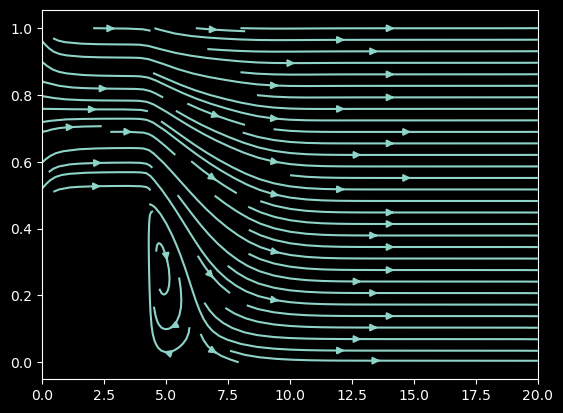

In [17]:
def main():
    cell_length = 1.0 / (N_POINTS_Y - 1)

    n_points_x = (N_POINTS_Y - 1) * ASPECT_RATIO + 1

    x_range = np.linspace(0.0, 1.0 * ASPECT_RATIO, n_points_x)
    y_range = np.linspace(0.0, 1.0, N_POINTS_Y)

    coordinates_x, coordinates_y = np.meshgrid(x_range, y_range)

    # Initial condition
    velocity_x_prev = np.ones((N_POINTS_Y + 1, n_points_x))
    velocity_x_prev[:(STEP_HEIGHT_POINTS + 1), :] = 0.0

    # Top Edge
    velocity_x_prev[-1, :] = - velocity_x_prev[-2, :]

    # Top Edge of the step
    velocity_x_prev[STEP_HEIGHT_POINTS, 1:STEP_WIDTH_POINTS] =\
        - velocity_x_prev[(STEP_HEIGHT_POINTS + 1), 1:STEP_WIDTH_POINTS]
    
    # Right Edge of the step
    velocity_x_prev[1:(STEP_HEIGHT_POINTS + 1), STEP_WIDTH_POINTS] = 0.0

    # Bottom Edge of the domain
    velocity_x_prev[0, (STEP_WIDTH_POINTS + 1):-1] =\
        - velocity_x_prev[1, (STEP_WIDTH_POINTS + 1):-1]
    
    # Values inside of the step
    velocity_x_prev[:STEP_HEIGHT_POINTS, :STEP_WIDTH_POINTS] = 0.0

    velocity_y_prev = np.zeros((N_POINTS_Y, n_points_x+1))

    pressure_prev = np.zeros((N_POINTS_Y+1, n_points_x+1))

    # Pre-Allocate some arrays
    velocity_x_tent = np.zeros_like(velocity_x_prev)
    velocity_x_next = np.zeros_like(velocity_x_prev)

    velocity_y_tent = np.zeros_like(velocity_y_prev)
    velocity_y_next = np.zeros_like(velocity_y_prev)

    # plt.style.use("dark_background")
    fig = plt.figure(figsize=(12, 8))
    
    # Lists to store data for video
    velocity_x_history = []
    velocity_y_history = []
    time_steps = []

    for iter in tqdm(range(N_TIME_STEPS)):
        # Update interior of u velocity
        diffusion_x = KINEMATIC_VISCOSITY * (
            (
                +
                velocity_x_prev[1:-1, 2:  ]
                +
                velocity_x_prev[2:  , 1:-1]
                +
                velocity_x_prev[1:-1,  :-2]
                +
                velocity_x_prev[ :-2, 1:-1]
                - 4 *
                velocity_x_prev[1:-1, 1:-1]
            ) / (
                cell_length**2
            )
        )
        convection_x = (
            (
                velocity_x_prev[1:-1, 2:  ]**2
                -
                velocity_x_prev[1:-1,  :-2]**2
            ) / (
                2 * cell_length
            )
            +
            (
                velocity_y_prev[1:  , 1:-2]
                +
                velocity_y_prev[1:  , 2:-1]
                +
                velocity_y_prev[ :-1, 1:-2]
                +
                velocity_y_prev[ :-1, 2:-1]
            ) / 4
            *
            (
                velocity_x_prev[2:  , 1:-1]
                -
                velocity_x_prev[ :-2, 1:-1]
            ) / (
                2 * cell_length
            )
        )
        pressure_gradient_x = (
            (
                pressure_prev[1:-1, 2:-1]
                -
                pressure_prev[1:-1, 1:-2]
            ) / (
                cell_length
            )
        )

        velocity_x_tent[1:-1, 1:-1] = (
            velocity_x_prev[1:-1, 1:-1]
            +
            TIME_STEP_LENGTH
            *
            (
                -
                pressure_gradient_x
                +
                diffusion_x
                -
                convection_x
            )
        )

        # Apply BC

        # Inflow
        velocity_x_tent[(STEP_HEIGHT_POINTS + 1):-1, 0] = 1.0

        # Outflow
        inflow_mass_rate_tent = np.sum(velocity_x_tent[(STEP_HEIGHT_POINTS + 1):-1, 0])
        outflow_mass_rate_tent = np.sum(velocity_x_tent[1:-1, -2])
        velocity_x_tent[1:-1, -1] =\
            velocity_x_tent[1:-1, -2] * inflow_mass_rate_tent / outflow_mass_rate_tent
        
        # Top edge of the step
        velocity_x_tent[STEP_HEIGHT_POINTS, 1:STEP_WIDTH_POINTS] =\
            - velocity_x_tent[STEP_HEIGHT_POINTS + 1, 1:STEP_WIDTH_POINTS]
        
        # Right edge of the step
        velocity_x_tent[1:(STEP_HEIGHT_POINTS + 1), STEP_WIDTH_POINTS] = 0.0

        # Bottom edge of the domain
        velocity_x_tent[0, (STEP_WIDTH_POINTS + 1):-1] =\
            - velocity_x_tent[1, (STEP_WIDTH_POINTS + 1):-1]
        
        # Top edge of the domain
        velocity_x_tent[-1, :] = - velocity_x_tent[-2, :]

        # Set all u-velocities to zero inside the step
        velocity_x_tent[:STEP_HEIGHT_POINTS, :STEP_WIDTH_POINTS] = 0.0

        # Update interior of v velocity
        diffusion_y = KINEMATIC_VISCOSITY * (
            (
                +
                velocity_y_prev[1:-1, 2:  ]
                +
                velocity_y_prev[2:  , 1:-1]
                +
                velocity_y_prev[1:-1,  :-2]
                +
                velocity_y_prev[ :-2, 1:-1]
                -
                4 * velocity_y_prev[1:-1, 1:-1]
            ) / (
                cell_length**2
            )
        )
        convection_y = (
            (
                velocity_x_prev[2:-1, 1:  ]
                +
                velocity_x_prev[2:-1,  :-1]
                +
                velocity_x_prev[1:-2, 1:  ]
                +
                velocity_x_prev[1:-2,  :-1]
            ) / 4
            *
            (
                velocity_y_prev[1:-1, 2:  ]
                -
                velocity_y_prev[1:-1,  :-2]
            ) / (
                2 * cell_length
            )
            +
            (
                velocity_y_prev[2:  , 1:-1]**2
                -
                velocity_y_prev[ :-2, 1:-1]**2
            ) / (
                2 * cell_length
            )
        )
        pressure_gradient_y = (
            (
                pressure_prev[2:-1, 1:-1]
                -
                pressure_prev[1:-2, 1:-1]
            ) / (
                cell_length
            )
        )

        velocity_y_tent[1:-1, 1:-1] = (
            velocity_y_prev[1:-1, 1:-1]
            +
            TIME_STEP_LENGTH
            *
            (
                -
                pressure_gradient_y
                +
                diffusion_y
                -
                convection_y
            )
        )

        # Apply BC

        # Inflow
        velocity_y_tent[(STEP_HEIGHT_POINTS + 1):-1, 0] =\
            - velocity_y_tent[(STEP_HEIGHT_POINTS + 1):-1, 1]
        
        # Outflow
        velocity_y_tent[1:-1, -1] = velocity_y_tent[1:-1, -2]

        # Top edge of the step
        velocity_y_tent[STEP_HEIGHT_POINTS, 1:(STEP_WIDTH_POINTS + 1)] = 0.0

        # Right edge of the step
        velocity_y_tent[1:(STEP_HEIGHT_POINTS + 1), STEP_WIDTH_POINTS] =\
            - velocity_y_tent[1:(STEP_HEIGHT_POINTS + 1), (STEP_WIDTH_POINTS + 1)]
        
        # Bottom edge of the domain
        velocity_y_tent[0, (STEP_WIDTH_POINTS + 1):] = 0.0

        # Top edge of the domain
        velocity_y_tent[-1, :] = 0.0

        # Set all v-velocities to zero inside of the edge
        velocity_y_tent[:STEP_HEIGHT_POINTS, :STEP_WIDTH_POINTS] = 0.0

        # Compute the divergence as it will be the rhs of the pressure poisson
        # problem
        divergence = (
            (
                velocity_x_tent[1:-1, 1:  ]
                -
                velocity_x_tent[1:-1,  :-1]
            ) / (
                cell_length
            )
            +
            (
                velocity_y_tent[1:  , 1:-1]
                -
                velocity_y_tent[ :-1, 1:-1]
            ) / (
                cell_length
            )
        )
        pressure_poisson_rhs = divergence / TIME_STEP_LENGTH

        # Solve the pressure correction poisson problem
        pressure_correction_prev = np.zeros_like(pressure_prev)
        for _ in range(N_PRESSURE_POISSON_ITERATIONS):
            pressure_correction_next = np.zeros_like(pressure_correction_prev)
            pressure_correction_next[1:-1, 1:-1] = 1/4 * (
                +
                pressure_correction_prev[1:-1, 2:  ]
                +
                pressure_correction_prev[2:  , 1:-1]
                +
                pressure_correction_prev[1:-1,  :-2]
                +
                pressure_correction_prev[ :-2, 1:-1]
                -
                cell_length**2
                *
                pressure_poisson_rhs
            )

            # Apply pressure BC: Homogeneous Neumann everywhere except for the
            # right where is a homogeneous Dirichlet

            # Inflow
            pressure_correction_next[(STEP_HEIGHT_POINTS + 1):-1, 0] =\
                pressure_correction_next[(STEP_HEIGHT_POINTS + 1):-1, 1]
            
            # Outflow
            pressure_correction_next[1:-1, -1] =\
                - pressure_correction_next[1:-1, -2]
            
            # Top edge of the step
            pressure_correction_next[STEP_HEIGHT_POINTS, 1:(STEP_WIDTH_POINTS + 1)] =\
                pressure_correction_next[(STEP_HEIGHT_POINTS + 1), 1:(STEP_WIDTH_POINTS + 1)]
            
            # Right edge of the step
            pressure_correction_next[1:(STEP_HEIGHT_POINTS + 1), STEP_WIDTH_POINTS] =\
                pressure_correction_next[1:(STEP_HEIGHT_POINTS + 1), (STEP_WIDTH_POINTS + 1)]
            
            # Bottom edge of the domain
            pressure_correction_next[0, (STEP_WIDTH_POINTS + 1):-1] =\
                pressure_correction_next[1, (STEP_WIDTH_POINTS + 1):-1]
            
            # Top edge of the domain
            pressure_correction_next[-1, :] = pressure_correction_next[-2, :]

            # Set all pressure (correction) values inside the step to zero
            pressure_correction_next[:STEP_HEIGHT_POINTS, :STEP_WIDTH_POINTS] = 0.0

            # Advance in smoothing
            pressure_correction_prev = pressure_correction_next
        
        # Update the pressure
        pressure_next = pressure_prev + pressure_correction_next

        # Correct the velocities to be incompressible
        pressure_correction_gradient_x = (
            (
                pressure_correction_next[1:-1, 2:-1]
                -
                pressure_correction_next[1:-1, 1:-2]
            ) / (
                cell_length
            )
        )

        velocity_x_next[1:-1, 1:-1] = (
            velocity_x_tent[1:-1, 1:-1]
            -
            TIME_STEP_LENGTH
            *
            pressure_correction_gradient_x
        )

        pressure_correction_gradient_y = (
            (
                pressure_correction_next[2:-1, 1:-1]
                -
                pressure_correction_next[1:-2, 1:-1]
            ) / (
                cell_length
            )
        )

        velocity_y_next[1:-1, 1:-1] = (
            velocity_y_tent[1:-1, 1:-1]
            -
            TIME_STEP_LENGTH
            *
            pressure_correction_gradient_y
        )

        # Again enforce BC
        
        # Inflow
        velocity_x_next[(STEP_HEIGHT_POINTS + 1):-1, 0] = 1.0

        # Outflow
        inflow_mass_rate_next = np.sum(velocity_x_next[(STEP_HEIGHT_POINTS + 1):-1, 0])
        outflow_mass_rate_next = np.sum(velocity_x_next[1:-1, -2])
        velocity_x_next[1:-1, -1] =\
            velocity_x_next[1:-1, -2] * inflow_mass_rate_next / outflow_mass_rate_next
        
        # Top edge of the step
        velocity_x_next[STEP_HEIGHT_POINTS, 1:STEP_WIDTH_POINTS] =\
            - velocity_x_next[STEP_HEIGHT_POINTS + 1, 1:STEP_WIDTH_POINTS]
        
        # Right edge of the step
        velocity_x_next[1:(STEP_HEIGHT_POINTS + 1), STEP_WIDTH_POINTS] = 0.0

        # Bottom edge of the domain
        velocity_x_next[0, (STEP_WIDTH_POINTS + 1):-1] =\
            - velocity_x_next[1, (STEP_WIDTH_POINTS + 1):-1]
        
        # Top edge of the domain
        velocity_x_next[-1, :] = - velocity_x_next[-2, :]

        # Set all u-velocities to zero inside the step
        velocity_x_next[:STEP_HEIGHT_POINTS, :STEP_WIDTH_POINTS] = 0.0
        
        # Inflow
        velocity_y_next[(STEP_HEIGHT_POINTS + 1):-1, 0] =\
            - velocity_y_next[(STEP_HEIGHT_POINTS + 1):-1, 1]
        
        # Outflow
        velocity_y_next[1:-1, -1] = velocity_y_next[1:-1, -2]

        # Top edge of the step
        velocity_y_next[STEP_HEIGHT_POINTS, 1:(STEP_WIDTH_POINTS + 1)] = 0.0

        # Right edge of the step
        velocity_y_next[1:(STEP_HEIGHT_POINTS + 1), STEP_WIDTH_POINTS] =\
            - velocity_y_next[1:(STEP_HEIGHT_POINTS + 1), (STEP_WIDTH_POINTS + 1)]
        
        # Bottom edge of the domain
        velocity_y_next[0, (STEP_WIDTH_POINTS + 1):] = 0.0

        # Top edge of the domain
        velocity_y_next[-1, :] = 0.0

        # Set all v-velocities to zero inside of the edge
        velocity_y_next[:STEP_HEIGHT_POINTS, :STEP_WIDTH_POINTS] = 0.0


        # Advance in time
        velocity_x_prev = velocity_x_next
        velocity_y_prev = velocity_y_next
        pressure_prev = pressure_next

        # inflow_mass_rate_next = np.sum(velocity_x_next[1:-1, 0])
        # outflow_mass_rate_next = np.sum(velocity_x_next[1:-1, -1])
        # print(f"Inflow: {inflow_mass_rate_next}")
        # print(f"Outflow: {outflow_mass_rate_next}")
        # print()

        # Store data for video creation
        if iter % PLOT_EVERY == 0:
            velocity_x_vertex_centered = (
                (
                    velocity_x_next[1:  , :]
                    +
                    velocity_x_next[ :-1, :]
                ) / 2
            )
            velocity_y_vertex_centered = (
                (
                    velocity_y_next[:, 1:  ]
                    +
                    velocity_y_next[:,  :-1]
                ) / 2
            )

            velocity_x_vertex_centered[:(STEP_HEIGHT_POINTS + 1),:(STEP_WIDTH_POINTS + 1)] = 0.0
            velocity_y_vertex_centered[:(STEP_HEIGHT_POINTS + 1),:(STEP_WIDTH_POINTS + 1)] = 0.0

            # Store velocity data for animation
            velocity_x_history.append(velocity_x_vertex_centered.copy())
            velocity_y_history.append(velocity_y_vertex_centered.copy())
            time_steps.append(iter)
    
    # Animation function following user's desired format
    def create_flow_animation(velocity_x_history, velocity_y_history, time_steps, 
                             coordinates_x, coordinates_y, cell_length):
        """
        Create animation of flow development over time
        """
        fig, ax = plt.subplots(figsize=(12, 8))
        # plt.style.use("dark_background")
        
        # Initial settings for contour levels
        levels = np.linspace(-1.5, 1.5, 21)
        
        # Velocity profile line positions and colors
        x_positions = [5, 40, 80, 180]
        colors = ['white', 'yellow', 'cyan', 'red']
        
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('y', fontsize=12)
        ax.set_title('Flow Over a Step Development', fontsize=14)
        ax.set_aspect('equal')
        
        # Time text display
        time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes,
                           fontsize=12, color='white',
                           bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
        
        def animate(frame):
            # Clear and update plot
            ax.clear()
            
            # Get velocity data for this frame
            u_data = velocity_x_history[frame]
            v_data = velocity_y_history[frame]
            time_step = time_steps[frame]
            
            # Create contour plot
            contour = ax.contourf(coordinates_x, coordinates_y, u_data, 
                                 levels=levels, cmap='RdBu_r', extend='both')
            
            # Add quiver plot for velocity vectors
            ax.quiver(coordinates_x[:, ::6], coordinates_y[:, ::6],
                     u_data[:, ::6], v_data[:, ::6],
                     alpha=0.4, color='black')
            
            # Add velocity profile lines at specific x positions
            for x_idx, color in zip(x_positions, colors):
                y = coordinates_y[:, x_idx]
                u_profile = u_data[:, x_idx]
                # Scale profile for visibility
                ax.plot(x_idx * cell_length + u_profile * 0.5, y, 
                       color=color, linewidth=2, label=f'x={x_idx*cell_length:.1f}')
            
            # Mark the step region
            step_x = [0, STEP_WIDTH_POINTS * cell_length, 
                     STEP_WIDTH_POINTS * cell_length, 0, 0]
            step_y = [0, 0, STEP_HEIGHT_POINTS * cell_length / (N_POINTS_Y - 1), 
                     STEP_HEIGHT_POINTS * cell_length / (N_POINTS_Y - 1), 0]
            ax.fill(step_x, step_y, color='gray', alpha=0.8)
            
            # Set labels and limits
            ax.set_xlabel('x', fontsize=12)
            ax.set_ylabel('y', fontsize=12)
            ax.set_title('Flow Over a Step Development', fontsize=14)
            ax.set_xlim(0, ASPECT_RATIO)
            ax.set_ylim(0, 1)
            ax.set_aspect('equal')
            
            # Add legend for velocity profiles
            # ax.legend(loc='upper right', fontsize=8, framealpha=0.5)
            
            # Update time text
            ax.text(0.01, 1.11, f'Time Step: {time_step}', 
                   transform=ax.transAxes, fontsize=12, color='white',
                   bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
            
            return [contour]
        
        # Create animation
        anim = animation.FuncAnimation(fig, animate, frames=len(velocity_x_history),
                                     interval=200, blit=False)
        
        return fig, anim
    
    # Create and save animation
    print("\nCreating flow animation...")
    plt.close(fig)  # Close the data collection figure
    
    fig_anim, anim = create_flow_animation(
        velocity_x_history, velocity_y_history, time_steps,
        coordinates_x, coordinates_y, cell_length
    )
    
    from IPython.display import HTML
    display(HTML(anim.to_jshtml()))
    
    plt.close(fig_anim)  # Close animation figure
    
    plt.figure()
    plt.streamplot(
        coordinates_x,
        coordinates_y,
        velocity_x_vertex_centered,
        velocity_y_vertex_centered,
    )

    plt.show()
    
    # Return animation object for potential use in Jupyter notebooks
    return anim

if __name__ == "__main__":
    animation_obj = main()
    

## 결론

후향 계단(backward-facing step) 유동의 주요 특징은 박리(separation)로 인한 **재순환 영역(Recirculation Zone)** 형성과 하류에서의 **속도 프로파일 재발달**로 요약된다. 계단 직후에 발생하는 유동 박리는 대규모 와류 구조(vortical structure)를 생성하며, 이 재순환 영역의 크기와 강도는 Reynolds 수에 강하게 의존한다. 특히 재부착점(reattachment point)의 위치는 전체 유동장의 압력 분포와 열전달 특성을 결정하는 중요한 인자로 작용한다. 속도 분포의 변화를 추적하면, 계단 상류의 완전 발달된 Hagen-Poiseuille 프로파일이 박리 이후 급격히 왜곡되었다가 하류에서 서서히 회복되는 과정을 관찰할 수 있다. 박리된 전단층(shear layer)은 재순환 영역과의 상호작용을 통해 복잡한 혼합 과정을 거치며, 포물선 속도 프로파일로의 완전한 재발달(redevelopment)은 일반적으로 계단 높이의 6-8배에 달하는 하류 거리에서 달성된다. 이러한 재발달 거리(redevelopment length)는 Reynolds 수와 계단의 기하학적 형상비(expansion ratio)에 따라 체계적으로 변화하는 것으로 알려져 있다.